#AmeniDC
## See the cost of amenities in the District of Columbia

In [2]:
%matplotlib inline
import matplotlib
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 4 * matplotlib.rcParams['savefig.dpi']
import matplotlib.pylab as plt

# Define amenity types of interest
AMENITY_TYPES = ['bakery','bar','cafe','grocery_or_supermarket',
  'movie_theater','park','pharmacy','restaurant','school','spa','subway_station']

valid_zipcodes = []
with open('./data/valid_zipcodes.txt','r') as f:
  valid_zipcodes = [line.strip() for line in f.readlines()]

In [3]:
import simplejson as json
import requests
from requests import Request, Session
from bs4 import BeautifulSoup
import re

from urlparse import urljoin
from collections import namedtuple
import sqlite3
from pyspark.sql import SQLContext

import numpy as np
import pandas as pd
import dill as pickle

import pprint
pp = pprint.PrettyPrinter(indent=0)

#OpenData.DC API

Get the property sale points from http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28
and store as a SQL database pandas DataFrame

In [ ]:
from ediblepickle import checkpoint


@checkpoint(key='prop_sales_json.csv', work_dir='data', refresh=False)
def request_records():
  url = 'http://opendata.dc.gov/datasets/2acc75ccdd954267acecb8713b2b800a_28.geojson'
  with requests.Session() as s:
    resp = s.get(url)
    try:
        resp.raise_for_status()
    except requests.exceptions.HTTPError as e:
        print "And you get an HTTPError:", e.message
  return resp.json()
  
  
def build_df(resp_json):
  keep_cols = [u'ADDRESS1',u'ADDRESS2',u'ANNUALTAX',u'ASSESSMENT',
               u'BASEBUILD',u'BASELAND',u'CITYSTZIP',
               u'HIGHNUMBER',u'HSTDCODE',u'LANDAREA',u'LOT',
               u'LOWNUMBER',u'NBHD',
               u'NEWIMPR',u'NEWLAND',u'NEWTOTAL',
               u'OLDIMPR',u'OLDLAND',u'OLDTOTAL',u'OWNOCCT',
               u'PREMISEADD',u'PROPTYPE',u'QDRNTNAME',u'SALEDATE',
               u'SALEPRICE',u'SALETYPE',u'SQUARE',u'SSL',u'STREETCODE',u'STREETNAME',
               u'SUBNBHD',u'coordinates']
    
  row_dicts = []
  for feats in resp_json['features']:
    try:
      # get coordinates
      row = dict(zip(['longitude','latitude'],feats['geometry']['coordinates']))
    except:
      continue
    attrs = feats['properties'] # get select property attributes
    row.update(dict(( (k,attrs.get(k,'')) for k in keep_cols )))
    row_dicts.append(row)
    
  df = pd.DataFrame(row_dicts)
  print df.columns

  df['lat_lng'] = df.loc[:,('latitude','longitude')].apply(
      lambda row: str(row[0])+','+str(row[1]),axis=1)

  df.to_hdf('./data/df_cleaned_wo_amen.hd5','df')
  

if False:
  resp_json = request_records()
  print resp_json['features'][0]
if False:
  build_df(resp_json)

Only keep residential single family residences

In [ ]:
if False:
  df = pd.read_hdf('./data/df_cleaned_wo_amen.hd5','df')
  print df['PROPTYPE'].unique()
  df = df.loc[df['PROPTYPE']==u'RESIDENTIAL-SINGLE FAMILY',:].copy()
  print df['PROPTYPE'].unique()
  df.to_hdf('./data/df_cleaned_res_only.hd5','df')


Parse the zipcodes and remove zipcodes that aren't in DC

In [ ]:
from sklearn import cross_validation, grid_search, neighbors

def zip_parser(x):
  z = x.split()[-1][:5]
  try:
    zint = int(z)
    if len(z) == 5:
      return z
    else:
      return u''
  except:
    return u''
  
if False:
  df = pd.read_hdf('./data/df_cleaned_res_only.hd5','df')
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))

  #print df.zipcode.unique()

  # extract zips from CITYSTZIP column
  df['zipcode'] = df.CITYSTZIP.map(lambda r: zip_parser(r))
  

  # Use nearest neighbors to fill in missing
  param_grid = {"n_neighbors": range(4,10)}
  zip_model = grid_search.GridSearchCV( neighbors.KNeighborsClassifier(),
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2,random_state=42) )

  zip_model.fit(df[['latitude','longitude']],df['zipcode'])
  for key in param_grid.keys():
    grid_score_plotter(zip_model,key)

  badzip = df.zipcode==''
  df.loc[badzip,'zipcode'] = zip_model.predict(df.loc[badzip,('latitude','longitude')])
  
  df.to_hdf('./data/df_cleaned_zipcodes.hd5','df')


# Google Maps Places API

Here, property sale locations are queried for nearby amenities. API requests were made once offline and pickled. Data for each lat_lng pair were stored as dict. 

Create a df column showing amenity_price_rating numbers for the top 20 hits within 1000m of the property

In [ ]:
if True:
  #df = pd.read_hdf('./data/df_cleaned_zipcodes.hd5','df')
  df = pd.read_hdf('./data/df_w_amen.hd5','df')


In [ ]:
if True:
  df = df.iloc[:15,:].copy()
  df.reset_index(inplace=True)

In [ ]:
len(df.columns)

In [ ]:
df['lat_lng'][0]

In [ ]:
import simplejson as json
import pandas as pd
from requests import Request, Sessio
from requests_futures.sessions import FuturesSession
from collections import namedtuple
import operator
import time


# Read in all API keys
with open("../secrets/google_secrets.json.nogit") as fh: 
  secrets = json.loads(fh.read())
google_api_key = secrets['server_api_key']

Summary = namedtuple('Summary',['count','count_rating','sum_rating','sum_rating_sq',
                               'count_price_level','sum_price_level','sum_price_level_sq'])

def google_places_parser(sess,resp):
  
  if False:
    print resp.json()['results'][0]
  
  count = 0
  count_rating = 0
  sum_rating = 0
  sum_rating_sq = 0
  count_price_level = 0
  sum_price_level = 0
  sum_price_level_sq = 0

  for r in resp.json()['results']:
    rating = r.get('rating')
    if rating:
      count_rating += 1
      sum_rating += float(rating)
      sum_rating_sq += float(rating)**2

    price_level = r.get('price_level')
    if price_level:
      count_price_level += 1
      sum_price_level += float(price_level)    
      sum_price_level_sq += float(price_level)**2    
    
    count += 1

  summary = Summary(count,count_rating,sum_rating,sum_rating_sq,
                   count_price_level,sum_price_level,sum_price_level_sq)

  resp.data = {'next_page_token':resp.json().get('next_page_token',''),
               'summary':summary}


def make_urls(npt_ll_series,amen_query):
  base_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
  s = Session()
  
  urls = []
  for row in npt_ll_series:
    npt, ll = row
    if npt == '':
      search_payload = {"key":google_api_key,
                        "radius":1000,
                        "types":amen_query,
                        "location":ll}
    else:
      '''Including a page token forces Google to ignore all other
      search parameters'''
      search_payload = {"key":google_api_key,
                        'pagetoken':npt}

    req = Request('GET', base_url, params=search_payload)

    urls.append(s.prepare_request(req).url)
  
  return urls

In [ ]:
# Build up the dataframe
from itertools import izip

session = FuturesSession(max_workers=7)

start_time = time.time()
for k in range(10,4,-1):
  amenity = AMENITY_TYPES[k]
  df['next_page_token'] = ''
  df[amenity] = df.apply(lambda _: Summary(0,0,0,0,0,0,0),axis=1)kkkjjj
  get_more = df.index
  
  for i in xrange(3):
    urls = make_urls(df.ix[get_more,('next_page_token','lat_lng')].as_matrix(),amenity)    
    results = (session.get(url,background_callback=google_places_parser) 
               for url in urls)
    outputs = ((x.result().data['next_page_token'],x.result().data['summary']) 
               for x in results)

    npts,summaries = izip(*outputs)
    df.ix[get_more,amenity] = pd.Series((Summary(*map(operator.add,x[0],x[1]))
                                for x in izip(df.ix[get_more,amenity],summaries)),index=get_more)
    df.ix[get_more,"next_page_token"] = npts

    get_more = df.index[df.next_page_token != '']
    
    print i,len(get_more)
    if len(get_more) == 0:
      break
    time.sleep(2) # delay because next page is not immediately available
  
  if True:
    df.to_hdf('./data/df_w_amen.hd5','df')
    
print("--- %s seconds ---" % (time.time() - start_time))



### Find count and mean of each amenity ###

In [ ]:
AMENITY_TYPES

In [ ]:
if True:`
  df = pd.read_hdf('./data/df_w_amen.hd5','df')


In [ ]:
if True:
  df = df.sample(100).copy()


In [ ]:
len(df.index)

In [ ]:
for amenity in AMENITY_TYPES:
  sum_cols = ['count','count_rating','mean_rating','std_rating',
              'count_price_level','mean_price_level','std_price_level']
  df = pd.concat( [df,pd.DataFrame.from_records(
                      df[amenity].map(lambda x: summarizer(x)).tolist(),
                      columns=[amenity + '_' + s for s in sum_cols],
                      index=df.index)], axis = 1
            )

In [ ]:
if True:
  df.to_hdf('./data/df_w_amen_flat.hd5','df')

#Visualize the data

In [ ]:
if True:
  df = pd.read_hdf('./data/df_w_amen_flat.hd5','df')
df = df.loc[df.zipcode.map(lambda x: x in valid_zipcodes),:]

In [ ]:
df[ 
  ['zipcode','SALEPRICE'] 
   + [col for col in df.columns if '_count' in col and '_count_' not in col]
   + [col for col in df.columns if 'mean_rating' in col or 'mean_price' in col]
  ].groupby('zipcode').mean().to_csv('./data/mean_by_zip_04.csv')

In [ ]:
zip_json = requests.get('http://opendata.dc.gov/datasets/5637d4bb43a34668b19fe630120d2b70_4.geojson')

In [ ]:
coords = []
for row in zip_json.json()['features']:
  coords.append(row['geometry'])

In [ ]:
coords

In [ ]:
pd.DataFrame(zip_json.json()['features'])

In [ ]:
df_zip = pd.read_json('http://opendata.dc.gov/datasets/5637d4bb43a34668b19fe630120d2b70_4.geojson')

In [ ]:
df_zip

In [ ]:
df_mean_count = df.groupby('zipcode')[['SALEPRICE']+[col for col in df.columns if '_count' in col and '_count_' not in col]].mean()

In [ ]:
df_mean_count.loc['20008',[col for col in df_mean_count.columns if col != 'SALEPRICE']].plot(kind='barh')


In [ ]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import FixedTicker

output_notebook()

```python
from bokeh.plotting import figure, show
from bokeh.models import Range1d

TOOLS="crosshair,pan,box_zoom,reset,box_select,lasso_select"

xlabel = 'Average Number of Amenities with 1km Radius'
ylabel = ''

this_row = df_mean_count.loc['20008',:]
p = figure(width=800, height=600, y_range=this_row.index.tolist(), tools=TOOLS)

p.background_fill = "#EAEAF2"

p.grid.grid_line_alpha=1.0
p.grid.grid_line_color = "white"

p.xaxis.axis_label = xlabel
p.xaxis.axis_label_text_font_size = '14pt'
p.xaxis.major_label_text_font_size = '14pt'
p.x_range = Range1d(0,50)
#p.xaxis[0].ticker=FixedTicker(ticks=[i for i in xrange(0,5,1)])

p.yaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = ylabel

p.yaxis.axis_label_text_font_size = '14pt'


j = 1
for k,v in this_row.iteritems():
  print k,v,j
  p.rect(x=v/2, y=j, width=v, height=0.4,color=(76,114,176),
    width_units="data", height_units="data")
  j += 1

show(p)
```

##Single Series bar chart

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Range1d

TOOLS="crosshair,pan,box_zoom,reset,box_select,lasso_select"

xlabel = 'Average Number of Amenities with 1km Radius'
ylabel = ''

this_row = df_mean_count.loc['20008',:]
p = figure(width=800, height=600, y_range=this_row.index.tolist(), tools=TOOLS)

p.background_fill = "#EAEAF2"

p.grid.grid_line_alpha=1.0
p.grid.grid_line_color = "white"

p.xaxis.axis_label = xlabel
p.xaxis.axis_label_text_font_size = '14pt'
p.xaxis.major_label_text_font_size = '14pt'
p.x_range = Range1d(0,50)
#p.xaxis[0].ticker=FixedTicker(ticks=[i for i in xrange(0,5,1)])

p.yaxis.major_label_text_font_size = '14pt'
p.yaxis.axis_label = ylabel
p.yaxis.axis_label_text_font_size = '14pt'

j = 1
for k,v in this_row.iteritems():
  print k,v,j
  p.rect(x=v/2, y=j, width=abs(v), height=0.4,color=(76,114,176),
    width_units="data", height_units="data")
  j += 1

show(p)

In [ ]:
p.x_range?

In [ ]:
df = pd.DataFrame( 
  {'SALEPRICE': {'20008': 901813.09850746265},
  'bakery_count': {'20008': 6.2850746268656712},
  'bar_count': {'20008': 25.435820895522387},
  'cafe_count': {'20008': 13.088059701492538},
  'grocery_or_supermarket_count': {'20008': 8.7253731343283576},
  'movie_theater_count': {'20008': 1.1417910447761195},
  'park_count': {'20008': 8.4074626865671647},
  'pharmacy_count': {'20008': 8.071641791044776},
  'restaurant_count': {'20008': 43.562686567164178},
  'school_count': {'20008': 18.622388059701493},
  'spa_count': {'20008': 6.4850746268656714},
  'subway_station_count': {'20008': 1.6850746268656716}} 
  )
df

In [ ]:
this_df.loc['20009',:].to_dict()

In [ ]:
def parse_column_name():
  '''Prepare the data to plot from the database'''
  this_df = pd.DataFrame(
    {'SALEPRICE': {'20008': 901813.09850746265},
    'bakery_count': {'20008': 6.2850746268656712},
    'bar_count': {'20008': 25.435820895522387},
    'cafe_count': {'20008': 13.088059701492538},
    'grocery_or_supermarket_count': {'20008': 8.7253731343283576},
    'movie_theater_count': {'20008': 1.1417910447761195},
    'park_count': {'20008': 8.4074626865671647},
    'pharmacy_count': {'20008': 8.071641791044776},
    'restaurant_count': {'20008': 43.562686567164178},
    'school_count': {'20008': 18.622388059701493},
    'spa_count': {'20008': 6.4850746268656714},
    'subway_station_count': {'20008': 1.6850746268656716}}
    )


  return this_df.append(
      pd.DataFrame.from_dict(
        {'query':
          {'SALEPRICE': 966153.51489868888,
          'bakery_count': 18.389749702026222,
          'bar_count': 56.282479141835516,
          'cafe_count': 41.280691299165674,
          'grocery_or_supermarket_count': 30.650774731823599,
          'movie_theater_count': 1.3510131108462455,
          'park_count': 19.90405244338498,
          'pharmacy_count': 23.856376638855782,
          'restaurant_count': 58.564362336114421,
          'school_count': 45.101907032181167,
          'spa_count': 16.930274135876044,
          'subway_station_count': 2.3134684147794995}
          }, orient='index')

In [ ]:
pd.DataFrame.from_dict({'query':{'SALEPRICE':100,'bar_count':50}},orient='index')

In [ ]:
df.append(pd.DataFrame.from_dict({'query':{'SALEPRICE':100,'bar_count':50}},orient='index'))

In [ ]:
from bokeh.plotting import figure, show
from bokeh.models import Range1d, LinearAxis, LogAxis

TOOLS="crosshair,pan,box_zoom,reset,box_select,lasso_select"


this_df = df_mean_count.loc[['20008','20009'],:]
p = figure(width=800, height=600, y_range=[col for col in reversed(this_df.columns.tolist())],
           tools=TOOLS)

# Set y axis properties
p.yaxis.axis_label = 'Amenity type'
p.yaxis.axis_label_text_font_size = '12pt'
p.yaxis.major_label_text_font_size = '12pt'

# Set primary x axis properties
p.xaxis.axis_label = 'Average Number of Amenities within 1km Radius'
p.xaxis.axis_label_text_font_size = '12pt'
p.xaxis.major_label_text_font_size = '12pt'
p.x_range = Range1d(0,60)

# Setting the second x axis range name and range
p.extra_x_ranges ={"saleprice": Range1d(start=0, end=10)}

# Adding the second axis to the plot.  
p.add_layout(LinearAxis(x_range_name="saleprice",
            axis_label='Sale price / $100,000',axis_label_text_font_size = '12pt'), 'above')
                  
                  
# Make background and grid look like seaborn
p.background_fill = "#EAEAF2"
p.grid.grid_line_alpha = 1.0
p.grid.grid_line_color = "white"


height = 0.4
offsets = np.linspace(-0.5,0.5,2)*height
colors = [(76,114,176),(253,141,60)]
j = len(this_df.columns)
for k,v in this_df.iteritems():
  print k,v.tolist()
  if k == 'SALEPRICE':
    x_range_name = 'saleprice'
    v /= 100000
  else:
    x_range_name = None

  for i in xrange(0,2):
    p.rect(x=v[i]/2, y=j+offsets[i], width=abs(v[i]), height=height, color=colors[i],
      width_units="data", height_units="data",x_range_name=x_range_name)
  j -= 1
  

show(p)

In [ ]:
def hist_plotter(df,cols,prefix=None,xlim=None):
  for attr in cols:
    plt.figure(figsize=(4,3))
    
    try:
      df[attr].hist(bins=np.linspace(xlim[0],xlim[1],21))
    except:
      pass
    plt.xlabel(attr)
    plt.ylabel('Number of sale locations')
    plt.xlim(xlim)
    plt.tight_layout()
    plt.savefig('./static/images/'+attr+'.png',frameon=False,dpi=450,pad_inches=0.1)

In [ ]:
hist_plotter(df,(col for col in df.columns if '_count' in col and '_count_' not in col),
             prefix='count_',xlim=(0,60))
hist_plotter(df,(col for col in df.columns if '_mean_rating' in col),
             prefix='rating_',xlim=(0,5))
hist_plotter(df,(col for col in df.columns if '_mean_price_level' in col),
             prefix='price_', xlim=(0,5))


In [ ]:
df

In [ ]:
def scatter_plotter(df,attr,title=None):
  df.plot(kind='scatter',x=attr,y='SALEPRICE',figsize=(4,3))
  plt.xlabel(attr)
  plt.yscale('log')
  plt.title(title)

In [ ]:
for name, group in df.groupby('zipcode'):
  #print name, len(group.index)
  if len(group.index)>5:
    scatter_plotter(group,'grocery_or_supermarket_mean_rating',name)

In [ ]:
scatter_plotter(group,'cafe_count')

#Do some modeling

In [ ]:
if False:
  df = pd.read_hdf('./data/df_w_amen_flat.hd5','df')
  df = df.loc[df.zipcode.map(lambda x: x in valid_zipcodes),:]

  stats_cols = ([col for col in df.columns if '_count' in col and '_count_' not in col]
            + [col for col in df.columns if 'mean_rating' in col and 'count' not in col]
            + [col for col in df.columns if 'mean_price_level' in col and 'count' not in col])
  col_list = ['SALEPRICE','latitude','longitude','LANDAREA','zipcode']+stats_cols
  df = df[col_list]
  df = df.fillna(df.mean())
  df = df.loc[:,np.logical_not(np.isnan(df.mean()))]
  new_col_list = [col for col in df.columns if col in col_list]
  new_stats_cols = [col for col in df.columns if col in stats_cols]
  df = df.loc[:,new_col_list]
  df.to_csv('./data/df_features.csv')

In [74]:
from pandas.tools.plotting import scatter_matrix

df = pd.read_csv('./data/df_features.csv')
count_cols = [c for c in df.columns if '_count' in c and '_count_' not in c]
rating_cols = [c for c in df.columns if '_mean_rating' in c]
price_cols = [c for c in df.columns if '_mean_price' in c]
lat_lng_cols = ['latitude','longitude']

#scatter_matrix(df[count_cols].sample(500),figsize=(11,11))

In [ ]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);

In [ ]:
plot_corr(df[count_cols])

In [ ]:
df[count_cols].corr().to_html('./templates/count_corr.html')
df[count_cols].corr()

In [ ]:
from itertools import repeat
dict(zip(rating_cols,repeat('%2.2f')))

In [ ]:
def fmtter(x):
  return '%2.2f' % 3.5

In [ ]:
np.linspace(-1,1,8)

In [ ]:
['rgb(%d,%d,%d)'% tuple(el) for el in (255*np.array(sns.color_palette("coolwarm", 7))).astype(np.int32).tolist()]

In [ ]:
AMENITY_TYPES

In [ ]:
def renamer(x):
  if 'SALEPRICE' in x: return 'Price'
  elif 'bar_' in x: return 'Bars'
  elif 'bakery_' in x: return 'Bakeries'
  elif 'cafe_' in x: return 'Cafes'
  elif 'grocery_' in x: return 'Groceries'
  elif 'movie_' in x: return 'Movies'
  elif 'park_' in x: return 'Parks'
  elif 'pharmacy_' in x: return 'Pharmacies'
  elif 'restaurant_' in x: return 'Restaurants'
  elif 'school_' in x: return 'Schools'
  elif 'spa_' in x: return 'Spas'
  elif 'subway_' in x: return 'Metros'
  
def formatter(x):
  return '%2.2f'%x

In [ ]:
df.columns

In [ ]:
df[['SALEPRICE']+count_cols].rename(columns=renamer).corr().to_html('./templates/count_corr.html',
                               formatters=[lambda x: '%2.2f'%x]*(len(count_cols)+1))
df[['SALEPRICE']+count_cols].rename(columns=renamer).corr()

In [ ]:
['SALEPRICE']+rating_cols

In [ ]:
df[['SALEPRICE']+rating_cols].rename(columns=renamer).corr().to_html('./templates/rating_corr.html',
                               formatters=[lambda x: '%2.2f'%x]*(len(rating_cols)+1))
df[['SALEPRICE']+rating_cols].rename(columns=renamer).corr()

In [ ]:
df[['SALEPRICE']+price_cols].rename(columns=renamer).corr().to_html('./templates/price_corr.html',
                                   formatters=[lambda x: '%2.2f'%x]*(len(price_cols)+1))
df[['SALEPRICE']+price_cols].rename(columns=renamer).corr()

In [ ]:
pd.concat?

In [27]:
from sklearn.decomposition import PCA

X = df[count_cols]
X = (X-X.mean())/X.std()
pca = PCA(n_components=10)

pd.concat((df[['SALEPRICE']],pd.DataFrame(pca.fit(X).transform(X))),axis=1).corr()

,SALEPRICE,0,1,2,3,4,5,6,7,8,9
SALEPRICE,1.000000,5.197293e-02,7.030126e-02,-2.561138e-03,-1.166630e-01,5.240946e-02,-4.956677e-02,1.251230e-01,6.539915e-02,-2.199234e-03,-3.937930e-02
0,0.051973,1.000000e+00,-1.381367e-14,-1.075540e-15,-4.953784e-15,4.623353e-15,5.697593e-14,1.060515e-14,3.198850e-15,1.188138e-14,-2.765305e-14
1,0.070301,-1.381367e-14,1.000000e+00,-2.276028e-15,1.779112e-15,-4.018164e-15,-1.364671e-14,-2.743205e-15,4.192934e-15,2.816453e-15,2.255128e-15
2,-0.002561,-1.075540e-15,-2.276028e-15,1.000000e+00,-1.567641e-15,1.236998e-15,1.126258e-14,2.250745e-15,-2.961028e-15,-2.114111e-15,-3.257824e-15
3,-0.116663,-4.953784e-15,1.779112e-15,-1.567641e-15,1.000000e+00,-7.090174e-16,-1.674712e-15,1.249961e-15,-1.263606e-16,-1.065453e-15,2.147597e-15
4,0.052409,4.623353e-15,-4.018164e-15,1.236998e-15,-7.090174e-16,1.000000e+00,4.601733e-15,-7.393086e-16,-4.441493e-16,2.092047e-15,-4.999144e-16
5,-0.049567,5.697593e-14,-1.364671e-14,1.126258e-14,-1.674712e-15,4.601733e-15,1.000000e+00,-5.339528e-15,-7.029173e-15,4.535638e-15,1.006466e-14
6,0.125123,1.060515e-14,-2.743205e-15,2.250745e-15,1.249961e-15,-7.393086e-16,-5.339528e-15,1.000000e+00,1.766451e-15,4.440958e-15,6.191108e-15
7,0.065399,3.198850e-15,4.192934e-15,-2.961028e-15,-1.263606e-16,-4.441493e-16,-7.029173e-15,1.766451e-15,1.000000e+00,-1.870944e-15,7.638994e-16
8,-0.002199,1.188138e-14,2.816453e-15,-2.114111e-15,-1.065453e-15,2.092047e-15,4.535638e-15,4.440958e-15,-1.870944e-15,1.000000e+00,1.234850e-16


In [36]:
from sklearn import cross_validation, grid_search

X = df[count_cols]
X = (X-X.mean())/X.std()
X = X.sample(10000)
y = df.loc[X.index,'SALEPRICE']
if 1:
  clf = PLSRegression(n_components=5)
  clf.fit(X,y)  
  print (np.abs(clf.predict(X).ravel()-y)).mean()

381185.301635


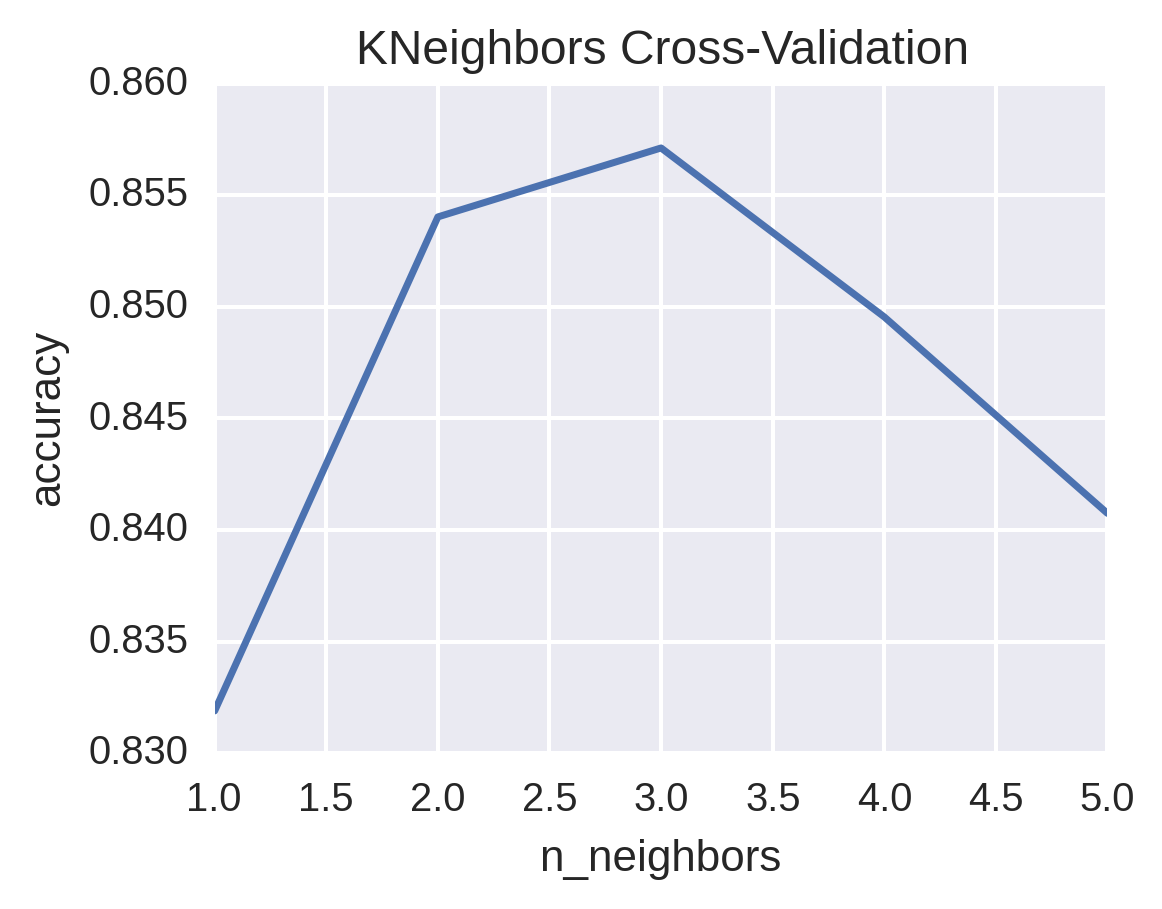

{'n_neighbors': 3}


In [111]:
from sklearn import cross_validation, grid_search
from sklearn import linear_model, neighbors, ensemble

if 0:
  X = df[count_cols]
  X = (X-X.mean())/X.std()
else:
  X = df[lat_lng_cols]
  X = (X-X.min())/(X.max()-X.min())
  
#X = X.sample(1000)
y = df.loc[X.index,'SALEPRICE']
if 0:
  clf = neighbors.KNeighborsRegressor(n_neighbors=1)
  if 1:
    pca = PCA(n_components=2)
    clf.fit(pca.fit(X).transform(X),y)
    print np.abs(clf.predict(pca.fit(X).transform(X))-y).mean()
  else:
    clf.fit(X,y)
    print np.abs(clf.predict(X)-y).mean()
else:
  if 1:
    param_grid = {'n_neighbors':range(1,6)}
    clf_CV = grid_search.GridSearchCV( neighbors.KNeighborsRegressor(),
                    param_grid=param_grid,
                    cv=cross_validation.ShuffleSplit(len(y), n_iter=20, 
                        test_size=0.2, random_state=42) )
  else:
    param_grid = {'min_samples_leaf':range(1,8)}
    clf_CV = grid_search.GridSearchCV( ensemble.RandomForestRegressor(),
                    param_grid=param_grid,
                    cv=cross_validation.ShuffleSplit(len(y), n_iter=20, 
                        test_size=0.2, random_state=42) )
  if 0:
    pca = PCA(n_components=10)
    clf_CV.fit(pca.fit(X).transform(X),y)
  else:
    clf_CV.fit(X,y)
    
  for key in param_grid.keys():
    grid_score_plotter(clf_CV,key,title='KNeighbors Cross-Validation')

  print clf_CV.best_params_
  


In [100]:
pd.concat((clf_CV.predict(X)-y,df[rating_cols]),axis=1).corr()

,SALEPRICE,bakery_mean_rating,bar_mean_rating,cafe_mean_rating,grocery_or_supermarket_mean_rating,movie_theater_mean_rating,park_mean_rating,pharmacy_mean_rating,restaurant_mean_rating,school_mean_rating,spa_mean_rating,subway_station_mean_rating
SALEPRICE,1.000000,0.004081,0.011056,0.015963,0.006590,0.011752,-0.001197,-0.006426,-0.010946,-0.008513,-0.008428,-0.007903
bakery_mean_rating,0.004081,1.000000,0.219744,0.343613,0.571452,0.152069,0.012050,0.019408,0.263135,0.175393,0.169943,0.091048
bar_mean_rating,0.011056,0.219744,1.000000,0.540661,-0.089489,0.057112,0.125718,-0.069584,0.260768,-0.116400,0.061080,0.002048
cafe_mean_rating,0.015963,0.343613,0.540661,1.000000,0.209389,0.186900,0.053338,-0.208733,0.341421,-0.163018,0.123174,-0.006856
grocery_or_supermarket_mean_rating,0.006590,0.571452,-0.089489,0.209389,1.000000,0.135263,-0.038972,0.081701,0.271998,0.246450,0.142298,0.108130
movie_theater_mean_rating,0.011752,0.152069,0.057112,0.186900,0.135263,1.000000,0.041475,-0.221240,0.119003,-0.085362,0.202103,0.005470
park_mean_rating,-0.001197,0.012050,0.125718,0.053338,-0.038972,0.041475,1.000000,-0.227491,0.170287,-0.108590,0.090530,-0.066481
pharmacy_mean_rating,-0.006426,0.019408,-0.069584,-0.208733,0.081701,-0.221240,-0.227491,1.000000,-0.164440,0.246933,0.215760,0.224928
restaurant_mean_rating,-0.010946,0.263135,0.260768,0.341421,0.271998,0.119003,0.170287,-0.164440,1.000000,-0.133750,0.052077,0.063272
school_mean_rating,-0.008513,0.175393,-0.116400,-0.163018,0.246450,-0.085362,-0.108590,0.246933,-0.133750,1.000000,-0.048751,-0.019043


In [11]:
from sklearn.svm import NuSVR
from sklearn import cross_validation, grid_search

X = df[count_cols]
X = (X-X.mean())/X.std()cc
X = X.sample(1000)
y = df.loc[X.index,'SALEPRICE']
if 0:
  clf = NuSVR(C=1.0, nu=0.1)
  clf.fit(X,y)  
  (np.abs(clf.predict(X)-y)).mean()

param_grid = {"nu": np.linspace(0.05,0.7,4),"C": np.logspace(-1,1,3)}
clf_CV = grid_search.GridSearchCV( NuSVR(),
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(y), n_iter=20, 
                    test_size=0.2, random_state=42) )
clf_CV.fit(X,y)

GridSearchCV(cv=ShuffleSplit(1000, n_iter=20, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=NuSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, gamma=0.0, kernel='rbf',
   max_iter=-1, nu=0.5, shrinking=True, tol=0.001, verbose=False),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'C': array([  0.1,   1. ,  10. ]), 'nu': array([ 0.05   ,  0.26667,  0.48333,  0.7    ])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

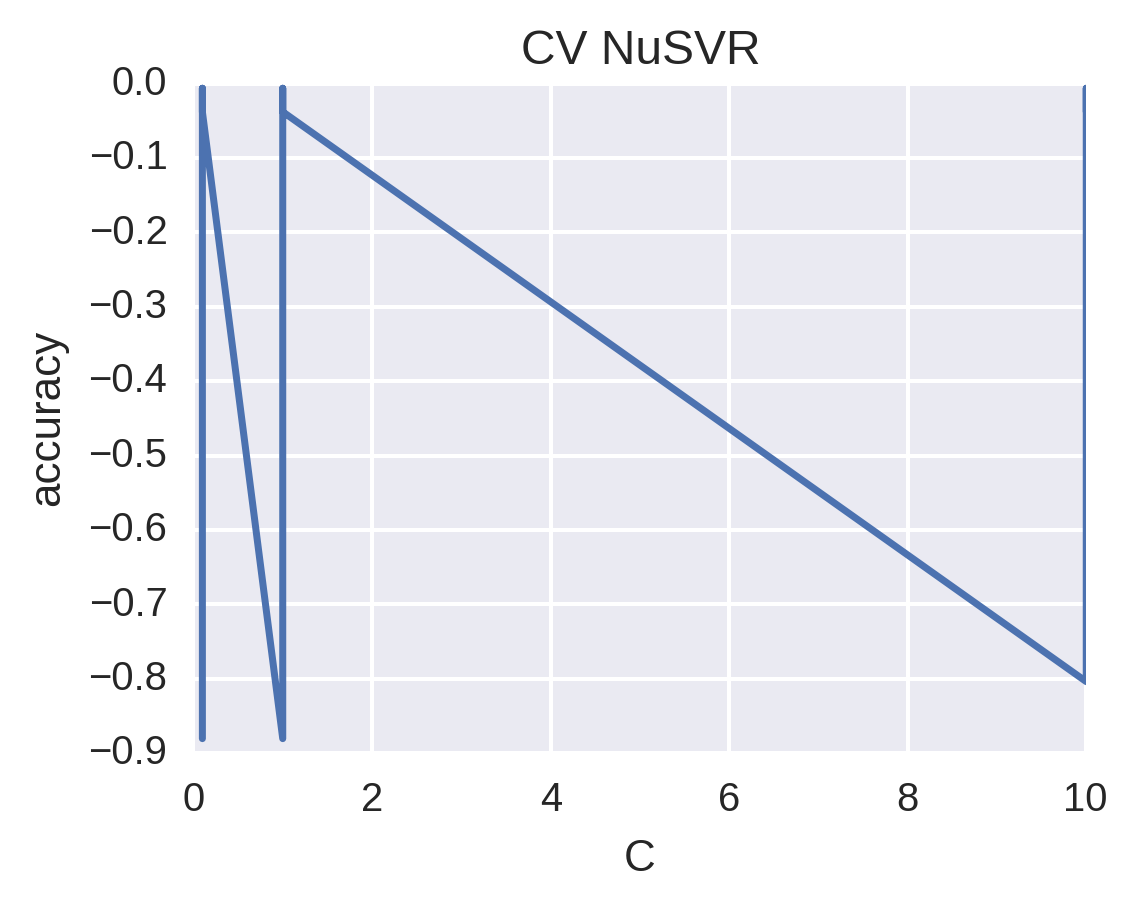

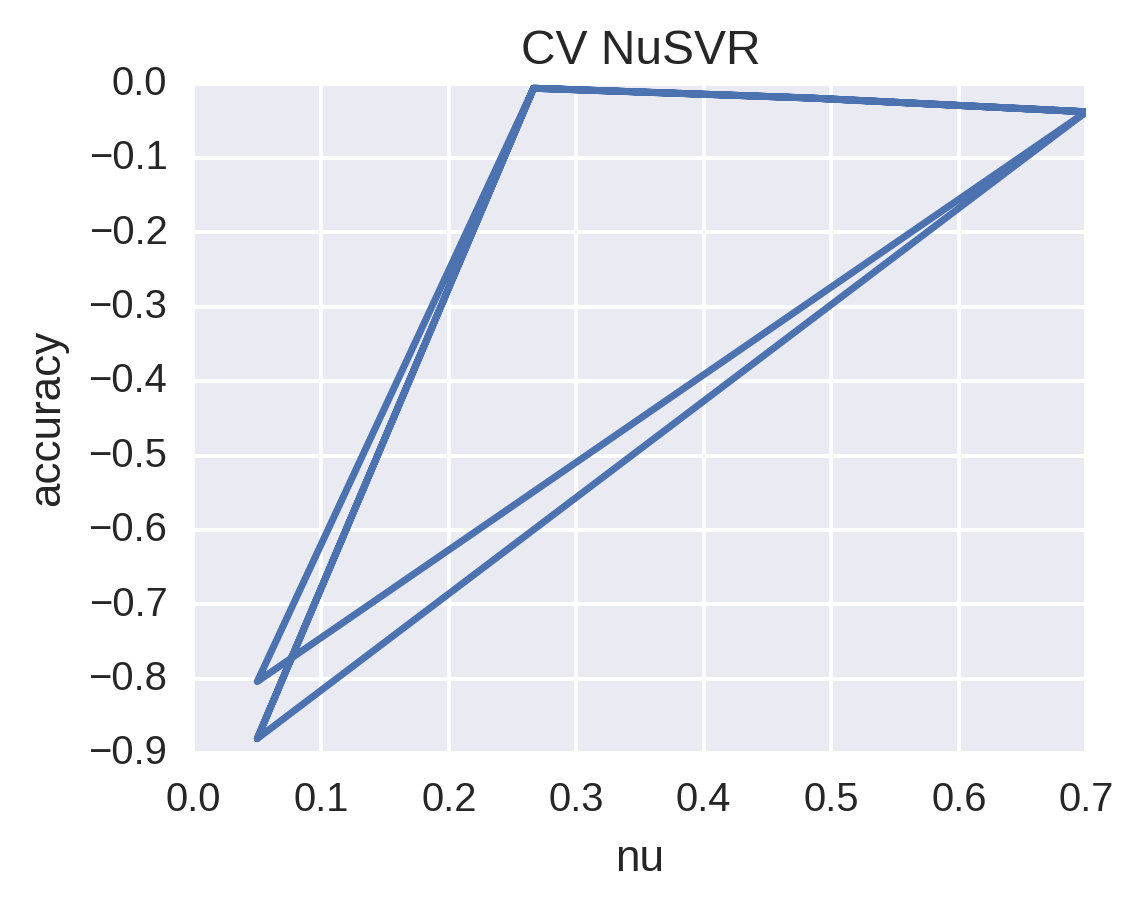

{'C': 10.0, 'nu': 0.26666666666666666}


In [12]:
for key in param_grid.keys():
  grid_score_plotter(clf_CV,key,title='CV NuSVR')

print clf_CV.best_params_

In [107]:
from sklearn import cross_validation, grid_search, neighbors
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn import linear_model

In [6]:
def grid_score_plotter(cv,param,title=None,xlabel=None):
  cv_accuracy = pd.DataFrame.from_records(
      [(score.parameters[param],
        score.mean_validation_score)
       for score in cv.grid_scores_],
  columns=[param, 'accuracy'])

  f = plt.figure(figsize=(4,3))
  plt.plot(cv_accuracy[param], cv_accuracy.accuracy)
  if xlabel is not None:
    plt.xlabel(xlabel)
  else:
    plt.xlabel(param)
  plt.ylabel('accuracy')
  plt.title(title)
  plt.show()
  if title is not None:
    plt.savefig('./static/images/'+title.replace(' ','_')+'.png',frameon=False,dpi=450,pad_inches=0.1)

In [108]:
class ColumnSelectTransformer(BaseEstimator, TransformerMixin):
  """
  Select columns of data from nd array
  """
  def __init__(self, columns, rescale=None):
    ''' columns must be list of strings '''
    self.columns = columns
    if rescale == "standard" or rescale=="range" or rescale==None:
      self.rescale = rescale
    else:
      raise NameError("rescale option must specify 'standard' or 'range'")

  def fit(self, X, y):
    return self

  def transform(self, X):
    ''' Assume X is pandas dataframe '''
    df = X[self.columns]
    if self.rescale == "standard":
      return (df-df.mean())/df.std()
    elif self.rescale == "range":
      return (df-df.min())/(df.max()-df.min())
    else:
      return df

## Build a predictive model using only latitude and longitude using K-nearest neighbors ##

In [109]:
lat_lng_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(['latitude','longitude'],rescale=None)),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
lat_lng_model_CV = grid_search.GridSearchCV( lat_lng_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

lat_lng_model_CV.fit(df,df.SALEPRICE)

GridSearchCV(cv=ShuffleSplit(12514, n_iter=20, test_size=0.2, random_state=42),
       error_score='raise',
       estimator=Pipeline(steps=[('sel', ColumnSelectTransformer(columns=['latitude', 'longitude'], rescale=None)), ('knn', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_neighbors=5, p=2, weights='uniform'))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'knn__n_neighbors': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None, scoring=None,
       verbose=0)

In [ ]:
for key in param_grid.keys():
  grid_score_plotter(lat_lng_model_CV,key,title='Cross Validation Using Lat-Long',
                        xlabel='Number of Neighbors')

print lat_lng_model_CV.best_params_

In [110]:
lat_lng_model = lat_lng_pipe.set_params(knn__n_neighbors=2)
lat_lng_model.fit(df,df.SALEPRICE)
computed_error = pd.DataFrame(
  {'lat_lng_err': abs(df.SALEPRICE - lat_lng_model.predict(df))
  })
print computed_error.mean()
lat_lng_model.get_params()


lat_lng_err    82974.636048
dtype: float64


{'knn': KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=2, p=2, weights='uniform'),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_neighbors': 2,
 'knn__p': 2,
 'knn__weights': 'uniform',
 'sel': ColumnSelectTransformer(columns=['latitude', 'longitude'], rescale=None),
 'sel__columns': ['latitude', 'longitude'],
 'sel__rescale': None}

In [ ]:
if 1:
  with open('./data/p_combo_model_rf.dpkl','wb') as p_output:
    pickle.dump(lat_lng_model,p_output)

In [ ]:
stats_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(new_stats_cols,rescale=None)),
    ('knn',neighbors.KNeighborsRegressor())
  ])

param_grid = {"knn__n_neighbors": range(1,6)}
stats_model_CV = grid_search.GridSearchCV( stats_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

stats_model_CV.fit(df,df.SALEPRICE)

In [ ]:
for key in param_grid.keys():
  f = grid_score_plotter(stats_model_CV,key,title='Cross Validation Using Amenities',
                        xlabel='Number of Neighbors')

print stats_model_CV.best_params_

In [ ]:


stats_pipe = Pipeline([
    ('sel',ColumnSelectTransformer(new_stats_cols,rescale=None)),
    ('model',ensemble.RandomForestRegressor(min_samples_leaf=3))
  ])

param_grid = {"model__min_samples_split": range(2,8,2)}
stats_model_CV = grid_search.GridSearchCV( stats_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

stats_model_CV.fit(df,df.SALEPRICE)

for key in param_grid.keys():
  grid_score_plotter(stats_model_CV,key)


In [ ]:
## Combo RF
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

combo_pipe = Pipeline([
    ('union',
       FeatureUnion([
              ('lat_lng_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['latitude','longitude'],rescale=None)),
                ])
              ),
              ('stats_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(new_stats_cols,rescale=None)),
                ])
              ),          
      ]) 
    ),  
    ('model',ensemble.RandomForestRegressor())
  ])

param_grid = {"model__min_samples_split": range(1,3),"model__min_samples_leaf": range(1,3)}
combo_model_CV = grid_search.GridSearchCV( combo_pipe,
                param_grid=param_grid,
                cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                    test_size=0.2, random_state=42) )

combo_model_CV.fit(df,df.SALEPRICE)

for key in param_grid.keys():
  grid_score_plotter(combo_model_CV,key)

computed_error['combo_error'] = abs(df.SALEPRICE - lat_lng_model.predict(df))

print computed_error.mean()
print combo_model_CV.best_params_


#combo_model = combo_pipe.fit(df,df.SALEPRICE)

In [ ]:
print np.mean(np.abs(combo_model.predict(df) - df.SALEPRICE))
if 1:
  with open('./data/p_combo_model_rf.dpkl','wb') as p_output:
    pickle.dump(combo_model,p_output)

In [ ]:
neighbors.KNeighborsRegressor?

In [ ]:
## Combo KNN
from sklearn import cross_validation, grid_search, neighbors, ensemble
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import linear_model

combo_pipe = Pipeline([
    ('union',
       FeatureUnion([
              ('landarea_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['LANDAREA'])),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),
              ('lat_lng_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(['latitude','longitude'])),
                  ('scaling', preprocessing.MinMaxScaler(copy=True)),
                ])
              ),
              ('stats_pipe',
                 Pipeline([
                  ('sel',ColumnSelectTransformer(new_stats_cols)),
                  ('scaling', preprocessing.StandardScaler(copy=True)),
                ])
              ),          
      ]) 
    ),  
    ('model',neighbors.KNeighborsRegressor())
  ])

if 1:
  param_grid = {"model__n_neighbors": range(1,9)}
  combo_model = grid_search.GridSearchCV( combo_pipe,
                  param_grid=param_grid,
                  cv=cross_validation.ShuffleSplit(len(df.index), n_iter=20, 
                      test_size=0.2, random_state=42) )

  combo_model.fit(df,df.SALEPRICE)

  for key in param_grid.keys():
    grid_score_plotter(combo_model,key)
else:
  combo_model = combo_pipe.fit(df,df.SALEPRICE)

In [ ]:
np.mean(np.abs(X.SALEPRICE-full_pipe.predict(X)))
